In [1]:
using Pkg

In [2]:
using DifferentialEquations

In [3]:
using Plots

In [4]:
#Pkg.add("Images")

In [5]:
#using Images

# Example

# High Power Rocket

In [4]:
function Rflag(R)
    if R < R0 - 10
        return 0
    else
        return 1
    end
end

Rflag (generic function with 1 method)

In [5]:
function amibent(h)
    if h < 11000
        T = 15.04 - 0.00649*h
        p = 101.29 * ((T+273.1)/(288.08))^(5.256)
    elseif 11000 <= h < 25000
        T = -56.46 
        p = 22.65 * exp(1.73-0.000157*h)
    elseif h >= 25000
        T = -131.21 + 0.00299*h 
        p = 2.488 * ((T+273.1)/216.6)^(-11.388)
    end  
    rho = p/(0.2869*(T+273.1))
    #return p * 1000,rho,T
    return rho
end

amibent (generic function with 1 method)

In [6]:
## return immediate thrust 
function Thrust(t)
    if -10 < t < t_inject_1
        return T1
    elseif t_inject_1 <= t < t_inject_2
        return T2
    else
        return 0.0
    end
end

Thrust (generic function with 1 method)

In [7]:
## return the exhaust mass flow rate
function Mass_Flow(t)
    if t < t_inject_1
        return mass_flow * 4.0
    elseif t_inject_1 <= t < t_inject_2
        return mass_flow
    else
        return 0.0
    end
end

Mass_Flow (generic function with 1 method)

## Falcon 1 Merlin 1A rocket engine, full-thrust version

## Falcon 9 Merlin 1D rocket engine, full-thrust version

In [28]:
##launch parameter
m_rocket = 33800.0
m_fuel1 = 367500.0
m_fuel2 = 140000.0

t_inject_1 = 330.0
t_inject_2 = 660.0

v_limit1 = 80.0
v_limit2 = 360.0
v_limit3 = 6000.0

p_e = 9.7 * 1000000

##engine parameter
mass_flow = 273.6
##Area_chamber = pi * 0.92^2 
##u_e = 3413
T1 = 7006000
T2 = 934000
##earth parameter
R0 = 6400000.0

k_aero = 3.7^2 * 0.25 * 1/2

## motion parameter
v_0 = 10.0

theta0 = deg2rad(90 - 6)

1.4660765716752369

In [29]:
## keep filght trajectory when the speed is low 
function theta_delay(v)
    if v < v_limit1
        return 0.0
    elseif v_limit1 <= v < v_limit2
        k = 1 + exp((v_limit1 + v_limit2)/2-v)
       return (1/k)
    elseif v_limit2 <= v < v_limit3
       k = 1
        return (1/k)
    else
        return 1
    end
end

theta_delay (generic function with 1 method)

$$
\left\{\begin{array}{l}
R^{\prime}=\nu \sin \theta \\
\varphi^{\prime}=\nu \frac{\cos \theta}{R} \\
a_{1}=\frac{T}{m} \\
a_{2}=-\frac{k_{\text {areo }} \rho v^{2}}{m} \\
a_{3}=-g \cos \theta \\
v^{\prime}=a_{1}+a_{2}+a_{3} \\
\theta^{\prime}=\frac{g \sin \theta}{\nu}-\frac{v \sin \theta}{r} \\
m^{\prime}=-m_{\text {mass_rate }}
\end{array}\right.
$$

In [30]:
function line1!(du,u,p,t)
    du[1] = Rflag(u[1]) * u[3] * sin(u[4])
    du[2] = Rflag(u[1]) * u[3] * cos(u[4])/u[1]
    a1 =  1*Thrust(t)./(u[5])
    #a2 = - k_aero .*(amibent(u[1] - R0)[2] .* u[3]^2)./(u[5])
    a2 = - k_aero .*(amibent(u[1] - R0) .* u[3]^2)./(u[5])
    a3 = - 9.8 * (R0/u[1])^2 *sin(u[4])
    du[3] =  a1 + a2 + a3
    du[4] = theta_delay(u[3]) *((u[3] * cos(u[4]))/u[1] - (9.8 * (R0/u[1])^2) * cos(u[4])/u[3])
    du[5] = - Mass_Flow(t)
end

line1! (generic function with 1 method)

In [31]:
m = m_fuel1 + m_fuel2 + m_rocket
u0 = [R0;0.0;v_0;theta0;m]
tspan = (0.0,t_inject_1)
prob = ODEProblem(line1!,u0,tspan)
sol1 = solve(prob,DP5(),dt=0.0001)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 14-element Array{Float64,1}:
   0.0
   0.0001
   0.0011
   0.0111
   0.11109999999999999
   1.1111
  11.111099999999999
  49.52632629739851
 118.36337391891192
 173.03400586703634
 265.95936547854427
 311.79123830903205
 327.89944170527997
 330.0
u: 14-element Array{Array{Float64,1},1}:
 [6.4e6, 0.0, 10.0, 1.4660765716752369, 541300.0]
 [6.400000000994538e6, 1.6332833396261238e-11, 10.000319621414892, 1.4660765716752369, 541299.89056]
 [6.400000010941664e6, 1.796898786202391e-10, 10.003515849836313, 1.4660765716752369, 541298.79616]
 [6.40000011058776e6, 1.8161315431966983e-9, 10.03547956130648, 1.4660765716752369, 541287.85216]
 [6.400001124537428e6, 1.846775562542336e-8, 10.355259408482496, 1.4660765716752369, 541178.4121600001]
 [6.400013018158511e6, 2.1379096927277895e-7, 13.567337937342112, 1.4660765716752369, 540084.01216]
 [6.400312638452186e6, 5.134191072787717e-6, 47.1224332157662, 1.4660765716752369

In [32]:
u0 = last(sol1) 
u0[5] = m_rocket + m_fuel2

tspan = (t_inject_1,t_inject_2)
prob = ODEProblem(line1!,u0,tspan)
sol2 = solve(prob,OwrenZen3(),dt=0.0001)

retcode: Success
Interpolation: specialized 3rd order "free" interpolation
t: 22-element Array{Float64,1}:
 330.0
 330.0001
 330.00109999999995
 330.01109999999994
 330.11109999999996
 331.11109999999996
 335.8802487021401
 343.54069986756565
 354.3385020016813
 368.8355292071569
 387.00576546958246
 408.80702385031645
 433.8159679004734
 461.47776207562754
 491.0137631664488
 521.5268239669876
 552.014081588481
 581.4416057201063
 608.7881349083169
 629.9056561619658
 646.7911852075107
 660.0
u: 22-element Array{Array{Float64,1},1}:
 [6.614328603991093e6, 0.06889636794858105, 4941.691307625519, 0.21192469414463694, 173800.0]
 [6.614328707935556e6, 0.06889644098903129, 4941.69165203235, 0.21192458567012112, 173799.97264]
 [6.614329747377698e6, 0.06889717139384431, 4941.695096111001, 0.2119235009260502, 173799.69904]
 [6.614340141550738e6, 0.06890447547303534, 4941.729537931317, 0.21191265359405867, 173796.96304]
 [6.61444405844361e6, 0.06897751937147058, 4942.074059516068, 0.2118041911

In [33]:
u0 = last(sol2) 
u0[5] = m_rocket

tspan = (t_inject_2,1400)
prob = ODEProblem(line1!,u0,tspan)
sol4 = solve(prob, Euler() ,dt = 30)

retcode: Success
Interpolation: 3rd order Hermite
t: 26-element Array{Float64,1}:
  660.0
  690.0
  720.0
  750.0
  780.0
  810.0
  840.0
  870.0
  900.0
  930.0
  960.0
  990.0
 1020.0
 1050.0
 1080.0
 1110.0
 1140.0
 1170.0
 1200.0
 1230.0
 1260.0
 1290.0
 1320.0
 1350.0
 1380.0
 1400.0
u: 26-element Array{Array{Float64,1},1}:
 [6.750888102174236e6, 0.3560820473761994, 7214.281414772976, -0.005338895510403579, 33800.0]
 [6.74973261882385e6, 0.38814084536808485, 7215.692113126175, -0.00990581917232516, 33800.0]
 [6.747588333654065e6, 0.4202102850156194, 7218.3103990174895, -0.014466204034624222, 33800.0]
 [6.744455796384442e6, 0.45229977283066475, 7222.13643711619, -0.019014493925963067, 33800.0]
 [6.740336286547901e6, 0.48441873591322665, 7227.169957455642, -0.02354513176512333, 33800.0]
 [6.735231818140396e6, 0.5165766274548305, 7233.410249834045, -0.02805256102918035, 33800.0]
 [6.72914514605311e6, 0.548782932209117, 7240.856155493566, -0.03253122719774415, 33800.0]
 [6.72207977429

In [43]:
u0 = last(sol2) 
u0[5] = m_rocket

tspan = (t_inject_2,40000)
prob = ODEProblem(line1!,u0,tspan)
sol3 = solve(prob, Euler() ,dt = 15)

retcode: Success
Interpolation: 3rd order Hermite
t: 2624-element Array{Float64,1}:
   660.0
   675.0
   690.0
   705.0
   720.0
   735.0
   750.0
   765.0
   780.0
   795.0
   810.0
   825.0
   840.0
     ⋮
 39840.0
 39855.0
 39870.0
 39885.0
 39900.0
 39915.0
 39930.0
 39945.0
 39960.0
 39975.0
 39990.0
 40000.0
u: 2624-element Array{Array{Float64,1},1}:
 [6.750888102174236e6, 0.3560820473761994, 7214.281414772976, -0.005338895510403579, 33800.0]
 [6.750310360499043e6, 0.37211144637214216, 7214.986763949575, -0.00762235734136437, 33800.0]
 [6.749485440377199e6, 0.3881435473788354, 7215.993960966984, -0.009904190374180388, 33800.0]
 [6.748413429234603e6, 0.40417952547316555, 7217.302984522992, -0.012183700129664599, 33800.0]
 [6.747094460037401e6, 0.42022055657492147, 7218.913786173511, -0.014460192155738072, 33800.0]
 [6.745528711396773e6, 0.4362678176179565, 7220.826290197046, -0.016732972074158744, 33800.0]
 [6.743716407701406e6, 0.45232248672085834, 7223.040393417376, -0.019001345

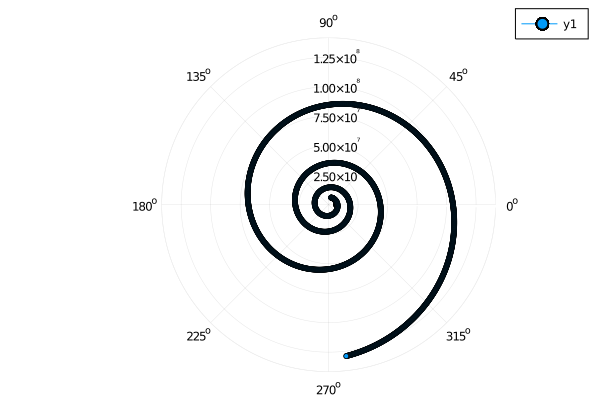

In [44]:
# phi1 = sol1[2,:]
r1 = sol1[1,:]

phi2 = sol2[2,:]
r2 = sol2[1,:]

phi3 = sol3[2,:]
r3 = sol3[1,:]

phi = vcat(phi1, phi2,phi3)
r = vcat(r1,r2,r3)

#phi = vcat(phi1, phi2)
#r = vcat(r1,r2)

plot(phi,r,proj = :polar, m = 3)

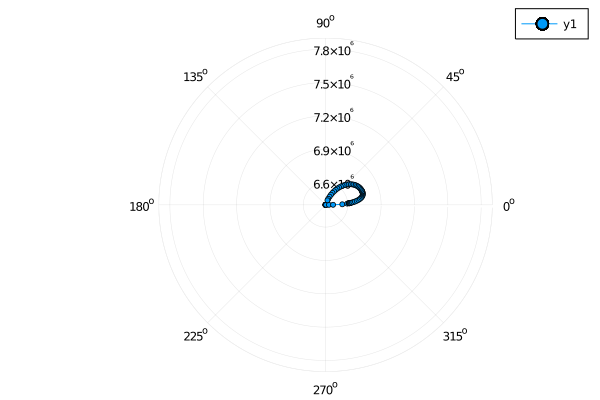

In [41]:
phi1 = sol1[2,:]
r1 = sol1[1,:]

phi2 = sol2[2,:]
r2 = sol2[1,:]

phi4 = sol4[2,:]
r4 = sol4[1,:]

launch_phi = vcat(phi1, phi2,phi4)
launch_r = vcat(r1,r2,r4)

plot(launch_phi,launch_r,proj = :polar, m = 3,ylims=(R0,R0+1500000))